In [47]:
import matplotlib.pyplot as plt # data plotting
import numpy as np # linear algebra
from dataclasses import *
from typing import Any, List, Tuple
import scipy.integrate as integrate
import scipy.optimize as optimize
import sys
sys.path.insert(0, '/Users/niyi/Documents/GitHub/Optimal-Control/Tools')
from EnforceTyping import enforce_method_typing, EnforceClassTyping
sys.path.insert(1, '/Users/niyi/Documents/GitHub/Optimal-Control/Code/Systems')
from ParticlesandFields import Field, ClassicalParticle


In [48]:
coulomb_constant = 8.9875e9  # N*m^2/C^2
@dataclass(kw_only=True)
class ElectrostaticField2D(Field):
  """
  A class used to represent a 2D Electrostatic Field

  Attributes
  ----------
  field_sources: dict
      a formatted string to print out what the animal says
  dimensionality: tuple
      a tuple of the dimensionality of the field  

  Methods
  -------
  dynamics(self, observation_position: np.ndarray, time: float) -> np.ndarray:
      Represents the value of the field at any given point(s) or time. 
  potential(self, observation_position: np.ndarray, time: float) -> float:
      Represents the potential due to the field at a given position and/or time  
  potential_difference(self, initial_position: np.ndarray, final_position: np.ndarray, time: float) -> float:
      Represents the potential difference between two positions at a given time in the vector field   
  gradient(self, observation_position: np.ndarray, time: float) -> float:
      Represents the gradient at a given position and/or time in the vector field 
  curl(self, observation_position: np.ndarray, time: float) -> float:
      Represents the curl at a given position and/or time in the vector field 
  divergence(self, observation_position: np.ndarray, time: float) -> float:
      Represents the divergence at a given position and/or time in the vector field
  """
  field_sources: dict
  dimensionality: tuple = (2,)

  def __call__(self, observation_position: np.ndarray) -> np.ndarray:
      return self.dynamics(observation_position)

  def __post_init__(self):
    assert len(self.field_sources["Particle"]) == len(self.field_sources["Position"]), "The length of particles and fields don't match"
    for field_source, _ in zip(self.field_sources["Particle"], self.field_sources["Position"]):
        assert isinstance(field_source, ClassicalParticle),  "The field source is not a particle" 

  @enforce_method_typing
  def dynamics(self, observation_position: np.ndarray) -> np.ndarray:
      """
      This function outputs the field strength due to field sources experienced at any given point(s) or time. 
      This determines the physics of the field (a 2D Electricstatic Field in this case)

      Args:
          observation_position (np.ndarray): The position.

      Returns:
          np.ndarray: The electric field strength vector at the given position.
      """
      electric_field_vector = np.zeros_like(observation_position)
      for field_source, source_position in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          position_vectors = np.broadcast_to(source_position, reversed(observation_position.shape)).T
          displacement_vectors = observation_position - position_vectors
          displacement_magnitude = np.linalg.norm(displacement_vectors, axis=0)
          electric_field_vector += (displacement_vectors * field_source.charge) / displacement_magnitude**3
      electric_field_vector = coulomb_constant * electric_field_vector
      return np.round(electric_field_vector, 3)  # N/C or V/m

  @enforce_method_typing
  def potential(self, observation_position: np.ndarray) -> float:
      """
      Calculate the potential (voltage) at a position in the field.

      Args:
          observation_position (np.ndarray): The position.

      Returns:
          np.ndarray: The electric potential at the given position.
      """
      electric_potential = 0.0
      for field_source, source_position in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          position_vectors = np.broadcast_to(source_position, reversed(observation_position.shape)).T
          displacement_vectors = observation_position - position_vectors
          displacement_magnitude = np.linalg.norm(displacement_vectors, axis=0)
          electric_potential += field_source.charge / displacement_magnitude
      electric_potential = coulomb_constant * electric_potential
      return np.round(electric_potential, 3)  # V

  @enforce_method_typing
  def potential_difference(self, initial_position: np.ndarray, final_position: np.ndarray) -> float:
    """
    Calculate the potential difference between the initial position and the final position in the field.

    Args:
        initial_position (np.ndarray): The starting position.
        final_position (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    assert initial_position.shape == self.dimensionality, "initial_position has the wrong dimensions"
    assert final_position.shape == self.dimensionality, "final_position has the wrong dimensions"
    PorentialDifference= self.potential(initial_position)- self.potential(final_position)
    return PorentialDifference

  @enforce_method_typing
  def gradient(self, observation_position: np.ndarray, delta: float= 0.001)->np.ndarray:
    """
    This function returns the derivative of the field at a given point

    Args:
        observation_position (np.ndarray): The position.
        delta (float, optional): The step size. Defaults to 0.001.

    Returns: 
      np.ndarray: The gradient of the field at the given position.
    """
    gradient= np.zeros_like(observation_position)
    for i in range(len(observation_position)):
      di= np.zeros_like(observation_position)
      di[i, ] = di[i, ]+delta
      plusdi= observation_position+ di
      minusdi= observation_position- di
      gradient[i]= (self.dynamics(plusdi)- self.dynamics(minusdi))[i]/ (2* delta)
    return gradient

  @enforce_method_typing
  def plot_field(self, low_bound= -5, high_bound= 5, n_vectors= 50):
    """
    This function plots the 2D electric vector field

    Args:
    low_bound (float, optional): The lower bound of the plot. Defaults to -5.
    high_bound (float, optional): The upper bound of the plot. Defaults to 5.
    n_vectors (int, optional): The number of vectors to plot. Defaults to 50.

    """
    observation_position= np.meshgrid(np.linspace(low_bound, high_bound, n_vectors), 
                                    np.linspace(low_bound, high_bound, n_vectors))
    observation_position= np.stack(observation_position)
    xd, yd = self.dynamics(observation_position)
    xd = xd / np.sqrt(xd**2 + yd**2)
    yd = yd / np.sqrt(xd**2 + yd**2)
    color_aara = np.sqrt(xd**2+ yd**2)
    fig, ax = plt.subplots(1,1)
    cp = ax.quiver(observation_position[0],observation_position[1],xd,yd,color_aara)
    fig.colorbar(cp)
    plt.rcParams['figure.dpi'] = 150
    plt.show()
    

In [49]:
negative_charge= ClassicalParticle(mass=1e-14, charge= -1e-9)
positive_charge= ClassicalParticle(mass=1e-14, charge= 1e-9)
sources = {"Particle": [negative_charge, positive_charge],
           "Position": [np.array([1.0, 1.0]), np.array([-1.0, 1.0])]} 

test_electric_field= ElectrostaticField2D(field_sources=sources)


In [50]:
@dataclass
class DirectCollocation(EnforceClassTyping):
    n_time_steps: int
    final_time: float
    initial_state: np.ndarray
    final_state: np.ndarray
    control_dims: tuple
    particle: ClassicalParticle
    
    def __post_init__(self):
      self.initial_guess= np.zeros(self.n_time_steps*(self.initial_state.size+ np.prod(self.control_dims)))
      self.initial_guess[:self.n_time_steps] = np.linspace(self.initial_state[0], self.final_state[0], self.n_time_steps)  # xPosition Initial Guess
      self.initial_guess[self.n_time_steps:2*self.n_time_steps] = np.linspace(self.initial_state[0], self.final_state[1], self.n_time_steps)  # yPosition Initial Guess
      self.initial_guess[2*self.n_time_steps:3*self.n_time_steps] = np.linspace(self.initial_state[0], self.final_state[2], self.n_time_steps)  # xVelocity Initial Guess
      self.initial_guess[3*self.n_time_steps:4*self.n_time_steps] = np.linspace(self.initial_state[0], self.final_state[3], self.n_time_steps)  # yVelocity Initial Guess
      self.time_interval= self.final_time/ (self.n_time_steps-1)
      self.optimal_trajectory= self.initial_guess

    def objective(self, trajectory: np.ndarray) -> float:
      px, py, vx, vy, ux, uy = trajectory.reshape(self.initial_state.size+ np.prod(self.control_dims), self.n_time_steps)
      return sum((vx**2 +vy**2)/2)*self.time_interval - sum((ux**2 +uy**2)/2)
    
    def state_dynamics(self, state: np.ndarray, time: float, control_force: np.ndarray):
      """
      Compute the dynamics of the particle's state.

      Parameters:
      state (np.ndarray): The current state of the particle [x, y, vx, vy].
      time (float): The current time.
      control_force (np.ndarray): The external control force applied to the particle.

      Returns:
      np.ndarray: The derivative of the state [vx, vy, ax, ay].
      """
      velocity = state[2:]
      acceleration = (self.particle.charge * test_electric_field.dynamics(state[:2]) + control_force) / self.particle.mass
      return np.concatenate((velocity, acceleration))
    
    def dynamics_constraint(self, trajectory: np.ndarray):
      px, py, vx, vy, ux, uy = trajectory.reshape(self.initial_state.size+ np.prod(self.control_dims), self.n_time_steps)
      x= np.vstack((px, py, vx, vy)).transpose()
      u= np.vstack((ux, uy)).transpose()
      ceq = []

      for k in range(self.n_time_steps-1):
        f_k = self.state_dynamics(state=x[k], time= 1.0, control_force=u[k])
        f_kp1 = self.state_dynamics(state=x[k+1], time= 1.0, control_force=u[k+1])
        ceq.append((x[k+1] - x[k]) - (self.time_interval * (f_k + f_kp1))/2)
      return np.array(ceq).transpose().flatten()
    
    def boundary_constraints(self, trajectory: np.ndarray):
      px, py, vx, vy, _, _= trajectory.reshape(self.initial_state.size+ np.prod(self.control_dims), self.n_time_steps)
      xi= np.vstack((px, py, vx, vy)).transpose()[0]
      xf= np.vstack((px, py, vx, vy)).transpose()[-1]
      x= np.concatenate((xi, xf), axis=None)
      x_bounds= np.concatenate((self.initial_state, self.final_state), axis=None)
      return x-x_bounds
    
    def solve(self):
        solution = optimize.minimize(self.objective, 
                                     self.initial_guess, 
                                     method='SLSQP', 
                                     constraints=({'type': 'eq', 'fun': self.dynamics_constraint}, 
                                                  {'type': 'eq', 'fun': self.boundary_constraints}))
        self.optimal_trajectory= solution.x
    
    def plot_trajectory(self):
      t = np.linspace(0, self.final_time, self.n_time_steps)
      px, py, vx, vy, ux, uy = self.optimal_trajectory.reshape(self.initial_state.size+ np.prod(self.control_dims), self.n_time_steps)
      plt.plot(px, py)
      plt.xlim(-5,5)
      plt.ylim(-5,5)
      plt.grid(True)
      plt.title('Optimal Path')
      plt.xlabel('x-Axis(m)')
      plt.ylabel('y-Axis(m)')
      plt.show()

      plt.plot(t, ux)
      plt.title('Optimal Control x')
      plt.xlabel('time(s)')
      plt.ylabel('y-Axis(m)')
      plt.show()

      plt.plot(t, uy)
      plt.title('Optimal Control y')
      plt.xlabel('time(s)')
      plt.ylabel('y-Axis(m)')
      plt.show()



/var/folders/qw/w54k7dcj4mlftnk6g2k3ys1w0000gn/T/ipykernel_80692/2654751718.py:57: RuntimeWarning: overflow encountered in scalar power
  electric_field_vector += (displacement_vectors * field_source.charge) / displacement_magnitude**3


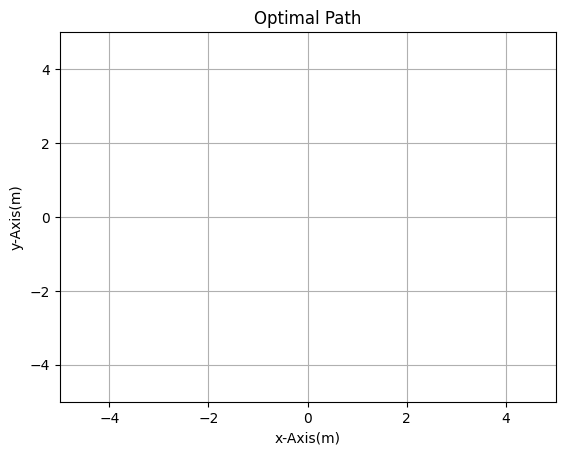

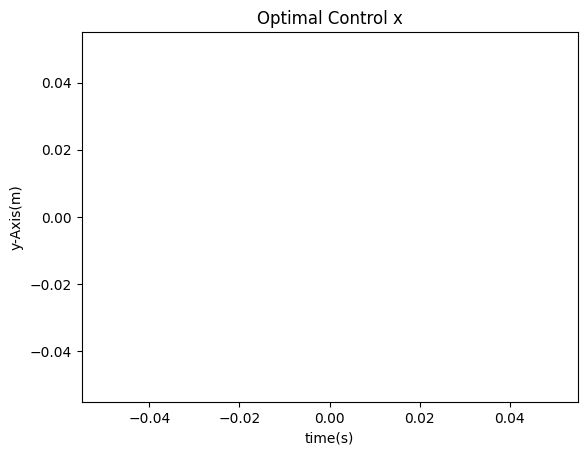

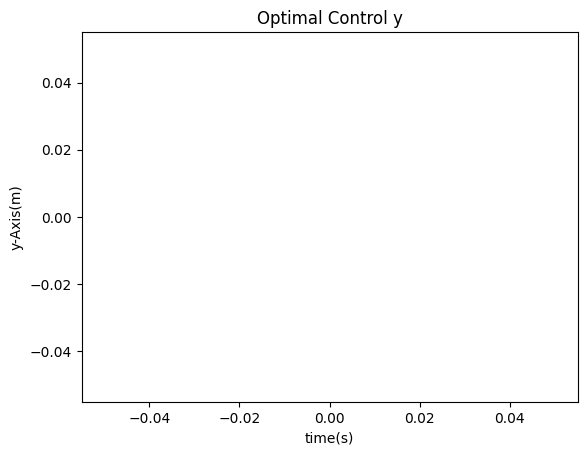

In [51]:
x_final= np.array([2.0, 2.0, 0.0, 0.0])
initial_state= np.array([0.0, 0.0, 0.0, 0.0])
Dc= DirectCollocation(100 , 5.0, initial_state, x_final, (2), negative_charge)
Dc.solve()
Dc.plot_trajectory()

In [52]:
Dc.objective(Dc.optimal_trajectory)

nan